In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import psycopg2
from local_settings import hostname, username, password, port, database

In [3]:
connection = psycopg2.connect(
            host=hostname, user=username, 
            password=password, dbname=database, 
            port=port
        )

In [4]:
sql_query = "SELECT * FROM data_row"

df = pd.read_sql_query(sql_query, connection)

connection.close()
print(df.shape)
df.head(3)

(26912, 19)


,title,address,price,area,bath,room,property_type,description,year,parking,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
2,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",162297,60,2,2,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania


Due to our own pruporse, we want to study those houses which label is 'Casa' or 'Departamento/Apartemento'. Then we drop out labels like 'Casa de playa', 'Casa de campo' and 'Habitación'.

In [5]:
outhome = ['Casa de playa', 'Casa de campo', 'Habitación']
mask = df['property_type'].apply(lambda x: x not in outhome)
df = df[mask]
df.shape

(26560, 19)

In [6]:
df['property_type'] = df['property_type'].str.replace('Apartamento', 'Departamento')
df['property_type'].value_counts()

property_type
Departamento    19226
Casa             7334
Name: count, dtype: int64

There some values which not correspond actually to Departments or Houses, but entire Hotels, buildings and so on.

In [7]:
id_mansion = df['title'].apply(lambda x: x.lower()).str.extract('((vend\w* edificio|hotel|hostel|mansion|mansión|hostal).*)').dropna().index
df = df.drop(index=id_mansion)
df.shape

(26483, 19)

In [8]:
df = df.drop_duplicates()
df.shape

(22429, 19)

We have already dropped duplicates instances out, but remains some values. So let's be more specific on which column we don't allow duplicates

In [9]:
df = df.drop_duplicates(subset=['address', 'price', 'area', 'bath', 'room', 'parking', 'year', 'property_type'])
df.shape

(21701, 19)

In [10]:
df['description'].fillna('', inplace=True)
df.isna().sum()

title            0
address          0
price            0
area             0
bath             0
room             0
property_type    0
description      0
year             0
parking          0
near_cc          0
near_school      0
near_parks       0
near_avenue      0
security         0
elevator         0
rest_area        0
pool             0
web              0
dtype: int64

In [11]:
df = df[df['bath'] != 0]
df.shape

(21681, 19)

Once again, due to our own pruporse we just consider departments priced lower than $250,000 and houses prices lower than $300,000

In [12]:
threshold_dep = 250000
threshold_casa = 300000
mask = ((df['property_type'] == 'Departamento') & (df['price'] < threshold_dep)) | ((df['property_type'] == 'Casa') & (df['price'] < threshold_casa))
df = df.loc[mask]
df['property_type'].value_counts()

property_type
Departamento    11531
Casa             2839
Name: count, dtype: int64

In [13]:
df['id'] = range(0,df.shape[0])
df.set_index('id', inplace=True)
df.head(2)

,title,address,price,area,bath,room,property_type,description,year,parking,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web
id,,,,,,,,,,,,,,,,,,,
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania


In [14]:
df['web'].value_counts()

web
Urbania    8961
Mitula     3251
Trovit     2158
Name: count, dtype: int64

# EDA

## Variable Distribution

Let's create a new dataframe which contains only the numerical variables, i.e., 'price', 'area', 'bath', 'room', 'parking' and 'year'.

In [15]:
df_num = df[['price', 'area', 'bath', 'room', 'parking', 'year', 'property_type']]
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14370 entries, 0 to 14369
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          14370 non-null  int64 
 1   area           14370 non-null  int64 
 2   bath           14370 non-null  int64 
 3   room           14370 non-null  int64 
 4   parking        14370 non-null  int64 
 5   year           14370 non-null  int64 
 6   property_type  14370 non-null  object
dtypes: int64(6), object(1)
memory usage: 898.1+ KB


As the first step, we plot the distribution of each variable in order to know where its outliers.

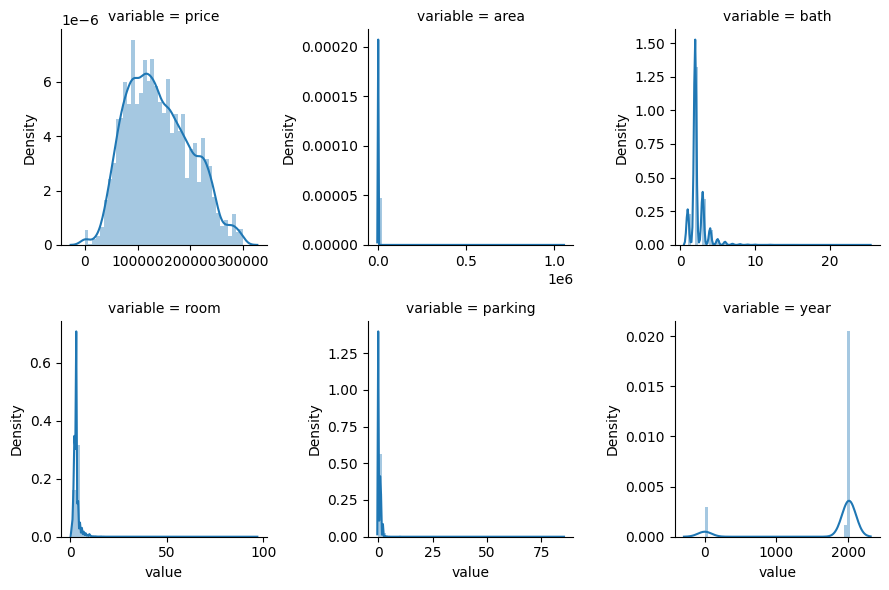

In [16]:
f = pd.melt(df_num.iloc[:,:-1], value_vars=df_num.columns[:-1])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

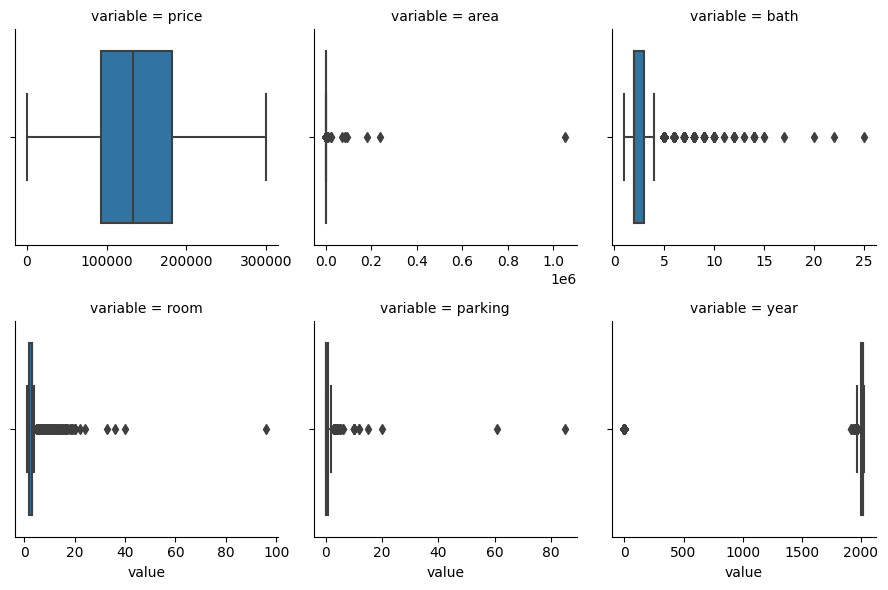

In [17]:
f = pd.melt(df_num.iloc[:,:-1], value_vars=df_num.columns[:-1])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

As we can appreciate, all variables have outliers, but 'price'. 

In [18]:
def outliers(column, df_outlier):
    Q1 = df_outlier[column].dropna().quantile(0.25)
    Q3 = df_outlier[column].dropna().quantile(0.75)
    IQR = Q3 - Q1

    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    return lower_whisker, upper_whisker

We point out for clients which buy its first house, then a housing which has a big area would not be a good option for a first house.

In [19]:
threshold = 500
mask = (df_num['area'] < threshold)
df_num = df_num[mask]
df_num.shape

(14189, 7)

## Outliers Casa & Departamento

Because Department and Houses has different dimensions and settings, we split the analysis among each property_type label.

In [20]:
mask = df_num['property_type'] == 'Departamento'
df_departamento = df_num.loc[mask]
mask = df_num['property_type'] == 'Casa'
df_casa = df_num.loc[mask]
print(df_departamento.shape, df_casa.shape)

(11509, 7) (2680, 7)


### Departamento

#### Outliers Area

We choose 'area' for our standard parameter, in order to contrast the other variables and take a decision aboout what instance gets drop out.

In [21]:
lower_darea, upper_darea = outliers('area', df_departamento)
lower_darea, upper_darea

(3.0, 171.0)

Hence using the outlier values, let's see which instance could be useful. For that a 2D histogram would be a good idea to see how data of 'area' and number of 'room' is distributed.

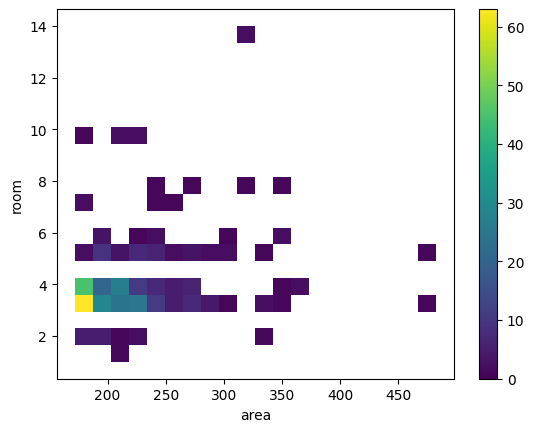

In [22]:
mask = df_departamento['area'] > upper_darea
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='area', y='room', bins=20, cmap='viridis', cbar=True)
plt.show()

For this data, let's see what is the most common range for number of rooms

In [23]:
mask = (df_departamento['area'] > upper_darea)
lower_room, upper_room = outliers('room', df_departamento[mask])
lower_room, upper_room

(1.5, 5.5)

According to this result, housing having more that 5 rooms and less than 3 room are dropped out.

In [24]:
mask = (df_departamento['area'] > upper_darea) & ((df_departamento['room'] <= 2)|(df_departamento['room'] >= 6))
print(df_departamento.loc[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(39, 7)


(11470, 7)

Let's do the same for 'bath' variable

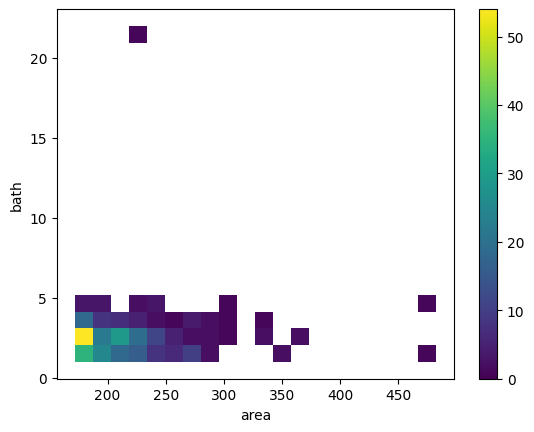

In [25]:
mask = df_departamento['area'] > upper_darea
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='area', y='bath', bins=20, cmap='viridis', cbar=True)
plt.show()

As well as before, instaces with more then 5 and less than 2 bath are dropped out.

In [26]:
mask = (df_departamento['area'] > upper_darea) & ((df_departamento['bath'] <= 1)|(df_departamento['bath'] >= 6))
print(df_departamento[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(5, 7)


(11465, 7)

#### Outliers Room & Bath

Now let's analyses the variables 'room' and 'bath' for itself.
Let's compute its outliers and let them go away.

In [28]:
lower_droom, upper_droom = outliers('room', df_departamento)
lower_droom, upper_droom

(0.5, 4.5)

In [29]:
mask = df_departamento['room'] < 5
print(df_departamento[~mask].shape)
df_departamento = df_departamento[mask]
df_departamento.shape

(113, 7)


(11352, 7)

In [30]:
lower_dbath, upper_dbath = outliers('bath', df_departamento)
lower_dbath, upper_dbath

(2.0, 2.0)

In [31]:
mask = df_departamento['bath'] < 5
print(df_departamento[~mask].shape)
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(27, 7)


(11325, 7)

#### Bath < Room

Now let's analyse both parameters together.

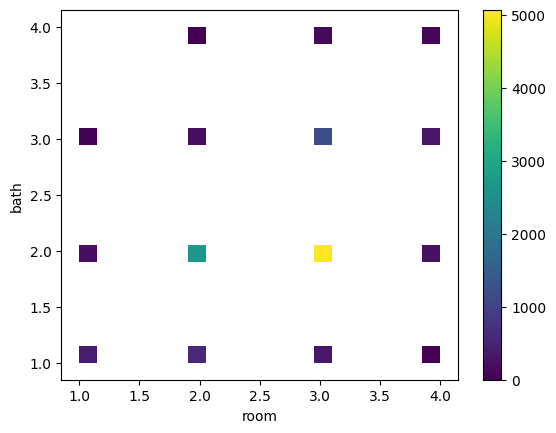

In [32]:
plt.figure()
sns.histplot(data=df_departamento.loc[mask], x='room', y='bath', bins=20, cmap='viridis', cbar=True)
plt.show()

We can appreciate than there are several cases where exist more bath than rooms. Let's drop out that instances.

In [33]:
mask = df_departamento['bath'] > df_departamento['room']
print(df_departamento[mask].shape)
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(509, 7)


(10816, 7)

#### Outlier Parking

In [34]:
lower_dparking, upper_dparking = outliers('parking', df_departamento)
lower_dparking, upper_dparking

(-1.5, 2.5)

In [35]:
mask = df_departamento['parking'] <= 2
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(10799, 7)

In [36]:
df_departamento['parking'] = df_departamento['parking'].replace(2, 1)
df_departamento.shape

(10799, 7)

In [37]:
df_departamento['parking'].value_counts()

parking
0    6846
1    3953
Name: count, dtype: int64

#### Outlier Year

There are some data in 'year' which is 0, let's replaced by random values, between 2000 and 2020

In [54]:
# mask = (df_departamento['year'] != 0) & (df_departamento['year'] != 2023) 
# new_year = int(df_departamento.loc[mask, 'year'].median())
mask = df_departamento['year'] == 0
size = df_departamento.loc[mask].shape[0]
df_departamento.loc[mask, 'year'] = np.random.normal(2010, 5, size).astype(int)
df_departamento.shape

(10799, 7)

In [62]:
mask = df_departamento['year'] > 2023
df_departamento.loc[mask, 'year'] = [2023] * df_departamento.loc[mask].shape[0]
df_departamento['year'] = df_departamento['year'].astype(int)
df_departamento['year'].value_counts()

year
2023    3917
2013     518
2022     512
2018     384
2008     341
        ... 
1932       1
1946       1
1947       1
1941       1
1950       1
Name: count, Length: 76, dtype: int64

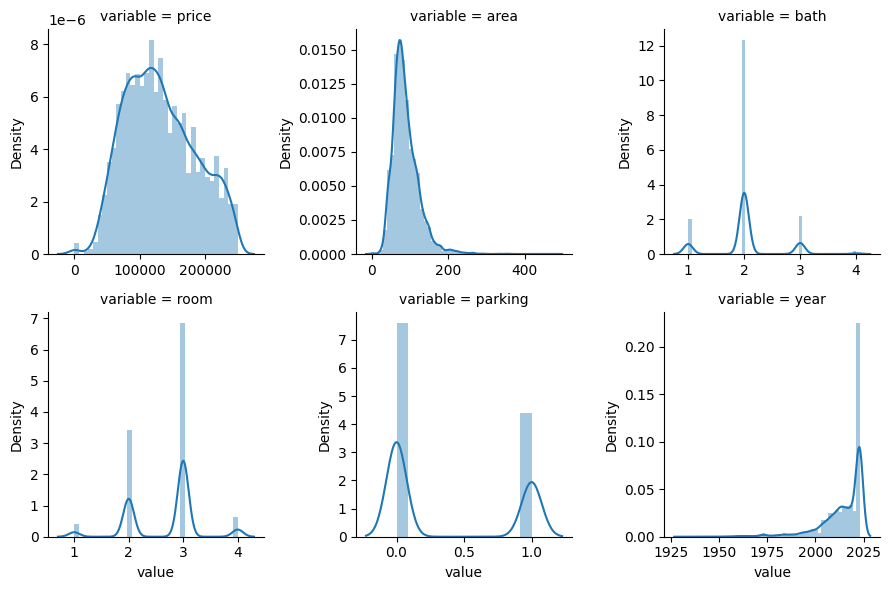

In [64]:
f = pd.melt(df_departamento.iloc[:,:-1], value_vars=df_departamento.columns[:-1])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

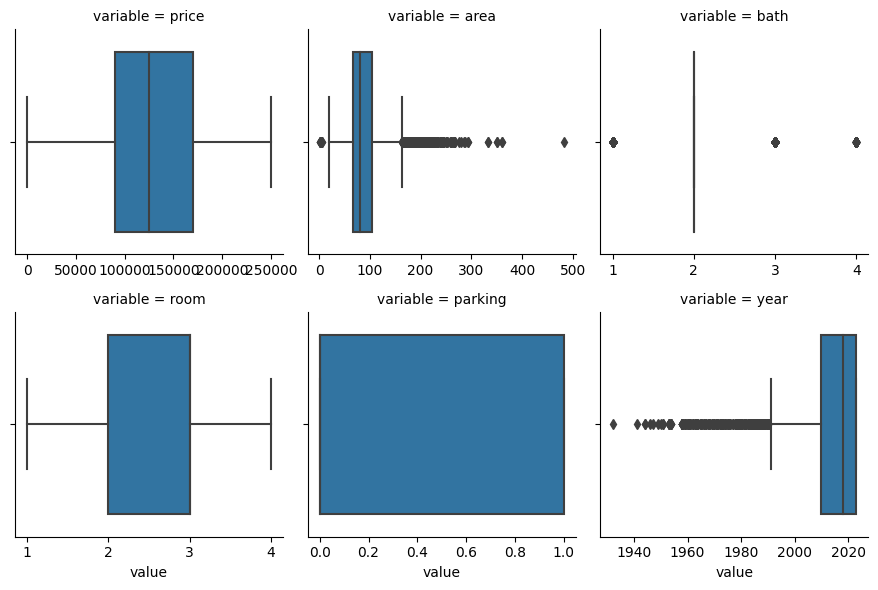

In [65]:
f = pd.melt(df_departamento.iloc[:,:-1], value_vars=df_departamento.columns[:-1])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

### Casa

#### Outliers Area

In [ ]:
lower_carea, upper_carea = outliers('area', df_casa)
lower_carea, upper_carea

(-91.25, 534.75)

In [ ]:
mask = df_casa['area'] > upper_carea
df_casa.loc[mask]

,price,area,bath,room,parking,year,property_type


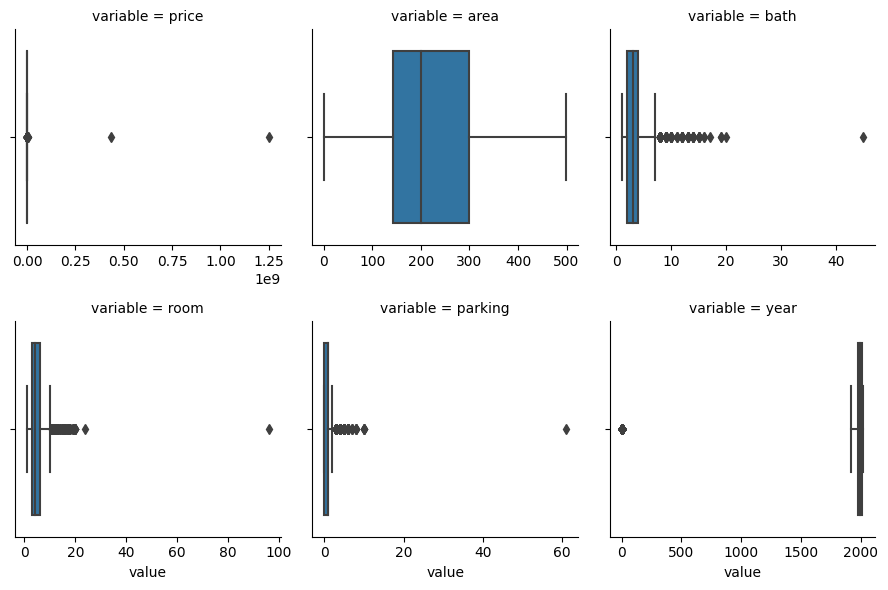

In [ ]:
f = pd.melt(df_casa.iloc[:,:-1], value_vars=df_num.columns[:-1])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

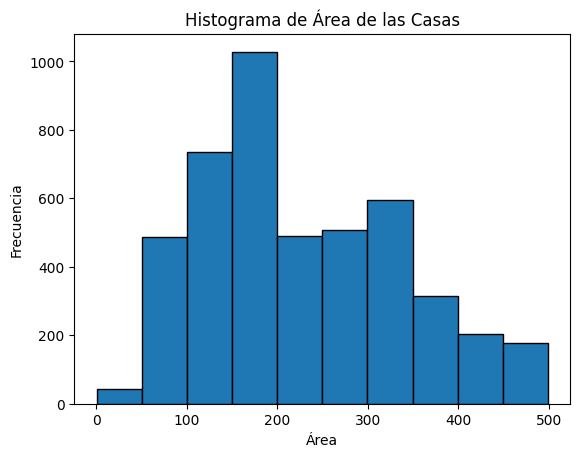

In [ ]:
plt.hist(df_casa["area"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Área")
plt.ylabel("Frecuencia")
plt.title("Histograma de Área de las Casas")

# Mostrar el gráfico
plt.show()


In [ ]:
mask = df_casa['area'] < 30
df_casa = df_casa.loc[~mask]

In [ ]:
#mask = df_casa['area'] > upper_carea
#plt.figure()
#sns.scatterplot(data=df_casa.loc[mask], x='area', y='room')
#plt.show()

In [ ]:
#mask = (df_departamento['area'] > upper_darea)
#lower_room, upper_room = outliers('room', df_departamento[mask])
#lower_room, upper_room

In [ ]:
#mask = (df_departamento['area'] > upper_darea) & ((df_departamento['room'] <= 2)|(df_departamento['room'] >= 6))
#df_departamento = df_departamento.loc[~mask]
#df_departamento.shape

In [ ]:
#mask = df_departamento['area'] > upper_darea
#plt.figure()
#sns.scatterplot(data=df_departamento.loc[mask], x='area', y='bath')
#plt.show()

In [ ]:
#mask = (df_departamento['area'] > upper_darea) & ((df_departamento['bath'] <= 1)|(df_departamento['bath'] >= 6))
#df_departamento = df_departamento.loc[~mask]
#df_departamento.shape

#### Outliers Room & Bath

In [ ]:
lower_croom, upper_croom = outliers('room', df_casa)
lower_croom, upper_croom

(-1.5, 10.5)

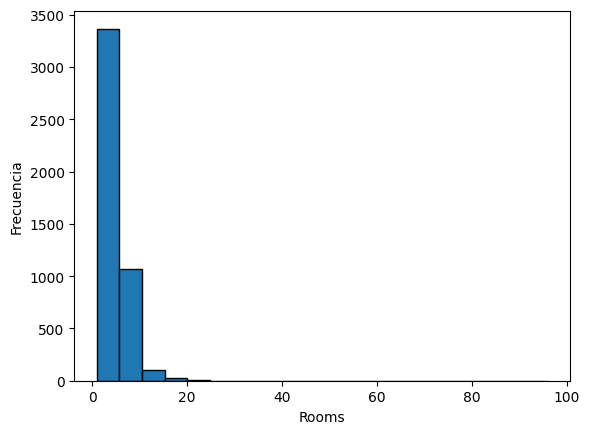

In [ ]:
plt.hist(df_casa["room"], edgecolor='k', bins= 20)

# Configurar etiquetas y título
plt.xlabel("Rooms")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
mask = df_casa['room'] > 10
df_casa = df_casa[~mask]
df_casa.shape

(4433, 7)

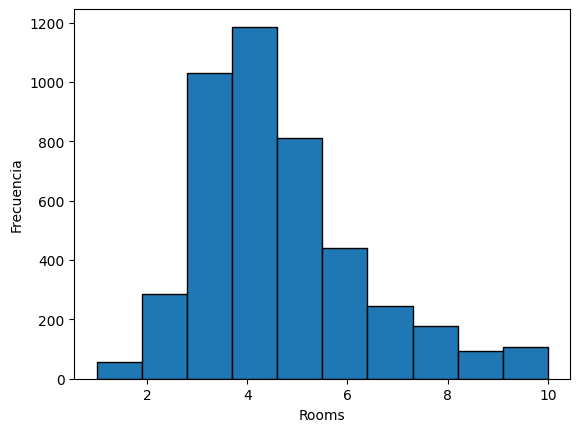

In [ ]:
plt.hist(df_casa["room"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Rooms")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
#id_hotel = df[df["room"] >10]['description'].apply(lambda x: x.lower()).str.extract('(hotel)').dropna().index
#df.loc[id_hotel]

In [ ]:
lower_cbath, upper_cbath = outliers('bath', df_casa)
lower_cbath, upper_cbath

(-1.0, 7.0)

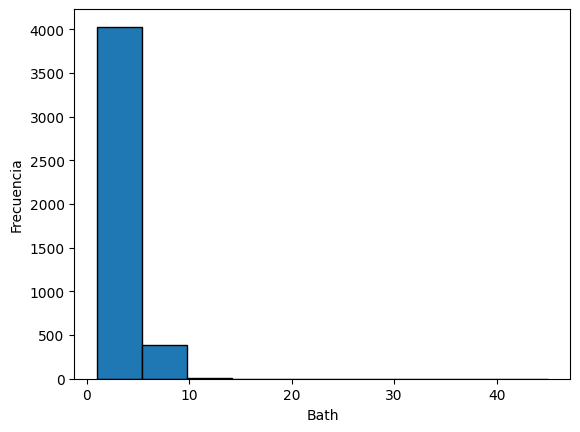

In [ ]:
plt.hist(df_casa["bath"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Bath")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
mask = df_casa['bath'] > 7
df_casa = df_casa[~mask]
df_casa.shape

(4366, 7)

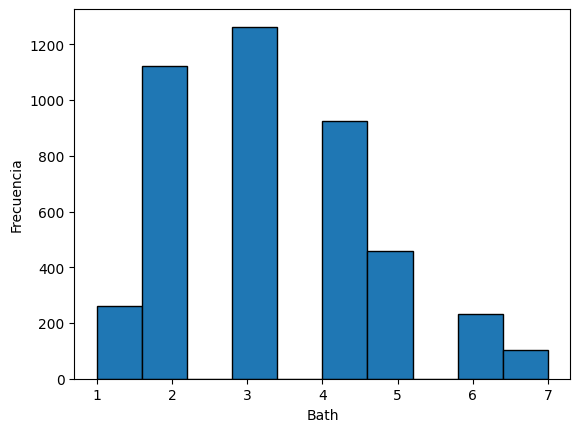

In [ ]:
plt.hist(df_casa["bath"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Bath")
plt.ylabel("Frecuencia")
plt.show()


#### Bath < Room

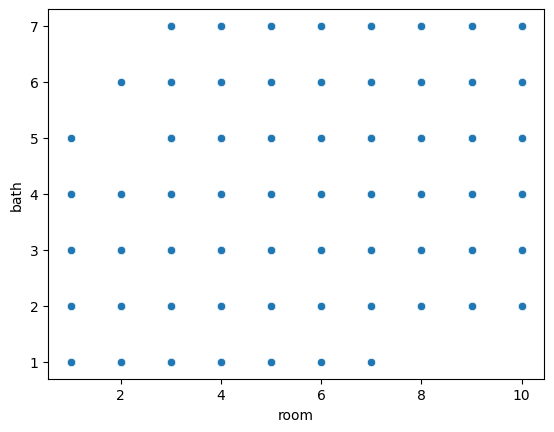

In [ ]:
plt.figure()
sns.scatterplot(data=df_casa, x='room', y='bath')
plt.show()

In [ ]:
mask = df_casa['bath'] > df_casa['room']
df_casa = df_casa.loc[~mask]
df_casa.shape

(3987, 7)

#### Outlier Parking

In [ ]:
lower_cparking, upper_cparking = outliers('parking', df_casa)
lower_cparking, upper_cparking

(-1.5, 2.5)

In [ ]:
mask = df_casa['parking'] <= 2
df_casa = df_casa.loc[mask]


In [ ]:
df_casa['parking'] = df_casa['parking'].replace(2, 1)
df_casa.shape

(3722, 7)

In [ ]:
df_casa['parking'].value_counts()

1    2012
0    1710
Name: parking, dtype: int64

#### Outlier Year

In [ ]:
df_casa.loc[df_casa['year'] == 0]

,price,area,bath,room,parking,year,property_type
236,205000,160,2,4,1,0,Casa
641,178378,338,2,4,0,0,Casa
1132,120000,120,2,4,1,0,Casa
1428,150000,53,2,3,0,0,Casa
1857,280000,360,5,6,1,0,Casa
...,...,...,...,...,...,...,...
26340,280000,270,3,4,0,0,Casa
26351,267800,200,3,6,0,0,Casa
26367,80000,140,3,4,1,0,Casa
26368,60000,120,1,2,0,0,Casa


In [ ]:
df_casa["year"].value_counts()

0       617
2023    220
2013    172
2003    153
1993    139
       ... 
1948      1
1951      1
1932      1
1947      1
1923      1
Name: year, Length: 85, dtype: int64

In [ ]:
mask = (df_casa['year'] != 0) & (df_casa['year'] != 2023) 
new_year = int(df_casa.loc[mask, 'year'].median())
df_casa['year'] = df_casa['year'].replace(0, new_year)
df_casa.shape

(3722, 7)

#### Outliers Price (REVISAR CON EDGAR)

In [ ]:
lower_cprice, upper_cprice = outliers('price', df_casa)
lower_cprice, upper_cprice

(-240000.0, 760000.0)

In [ ]:
mask = df_casa['price'] > 300000
df_casa = df_casa.loc[~mask]

In [ ]:
mask = df_casa['price'] > 100
df_casa = df_casa.loc[mask]
df_casa.shape

(2409, 7)